### DEMAND FORECASTING PIPELINE
Orginal code from "https://github.com/priyalingutla/30-Days-Of-Data/blob/main/End-to-End%20Forecasting%20Pipeline%20DAY%202%20%2330daysofdata.ipynb"

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
from scipy import stats
import time
import pickle

#matplotlib libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

#date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

#prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

#pandas options
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#matplotlib setting defaults
sns.set(font="Arial",
        rc={
 "axes.axisbelow": False,
 "axes.edgecolor": "lightgrey",
 "axes.facecolor": "None",
 "axes.grid": False,
 "axes.labelcolor": "dimgrey",
 "axes.spines.right": False,
 "axes.spines.top": False,
 "figure.facecolor": "white",
 "lines.solid_capstyle": "round",
 "patch.edgecolor": "w",
 "patch.force_edgecolor": True,
 "text.color": "dimgrey",
 "xtick.bottom": False,
 "xtick.color": "dimgrey",
 "xtick.direction": "out",
 "xtick.top": False,
 "ytick.color": "dimgrey",
 "ytick.direction": "out",
 "ytick.left": False,
 "ytick.right": False})

In [2]:
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

def mape(actual, pred): 
    '''
    Mean Absolute Percentage Error (MAPE) Function
    
    input: list/series for actual values and predicted values
    output: mape value 
    '''
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

### READING IN DATA
Sales dataset from kaggle from Favorita stores in Ecuador. (ref: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data?select=train.csv)

In [4]:
df = pd.read_csv('../data/store_data.csv')
df.columns = df.columns.str.replace(' ', '_').str.lower()

df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")

In [5]:
min(df['date']), max(df['date'])

(Timestamp('2013-01-01 00:00:00'), Timestamp('2017-08-15 00:00:00'))

In [6]:
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0
1,1,2013-01-01,1,BABY CARE,0.00,0
2,2,2013-01-01,1,BEAUTY,0.00,0
3,3,2013-01-01,1,BEVERAGES,0.00,0
4,4,2013-01-01,1,BOOKS,0.00,0


Let's aggregate the dataset to the "family" and "sales" daily level so that we can have high volume metrics for demand forecasting throughout the country. The line of code below can also be done in SQL.
<i>select date,
        family, 
        sum(sales)
from df
group by date, family
</i>

In [7]:
agg_df = df.groupby(['date','family']).agg({'sales':'sum'}).reset_index().sort_values(['family','date'])

In [9]:
agg_df.head()

,date,family,sales
0,2013-01-01,AUTOMOTIVE,0.00
33,2013-01-02,AUTOMOTIVE,255.00
66,2013-01-03,AUTOMOTIVE,161.00
99,2013-01-04,AUTOMOTIVE,169.00
132,2013-01-05,AUTOMOTIVE,342.00


keep only {BREAD/BAKERY, DAIRY, DELI, GROCERY I, FROZEN FOODS}

In [10]:
mask = (agg_df['family']=='BREAD/BAKERY') | (agg_df['family']=='DAIRY') | (agg_df['family']=='DELI') | (agg_df['family']=="GROCERY I") |(agg_df['family']=="FROZEN FOODS") 
agg_df =agg_df[mask]

In [11]:
agg_df.head()

,date,family,sales
5,2013-01-01,BREAD/BAKERY,180.59
38,2013-01-02,BREAD/BAKERY,26246.32
71,2013-01-03,BREAD/BAKERY,18456.48
104,2013-01-04,BREAD/BAKERY,16721.97
137,2013-01-05,BREAD/BAKERY,22367.76


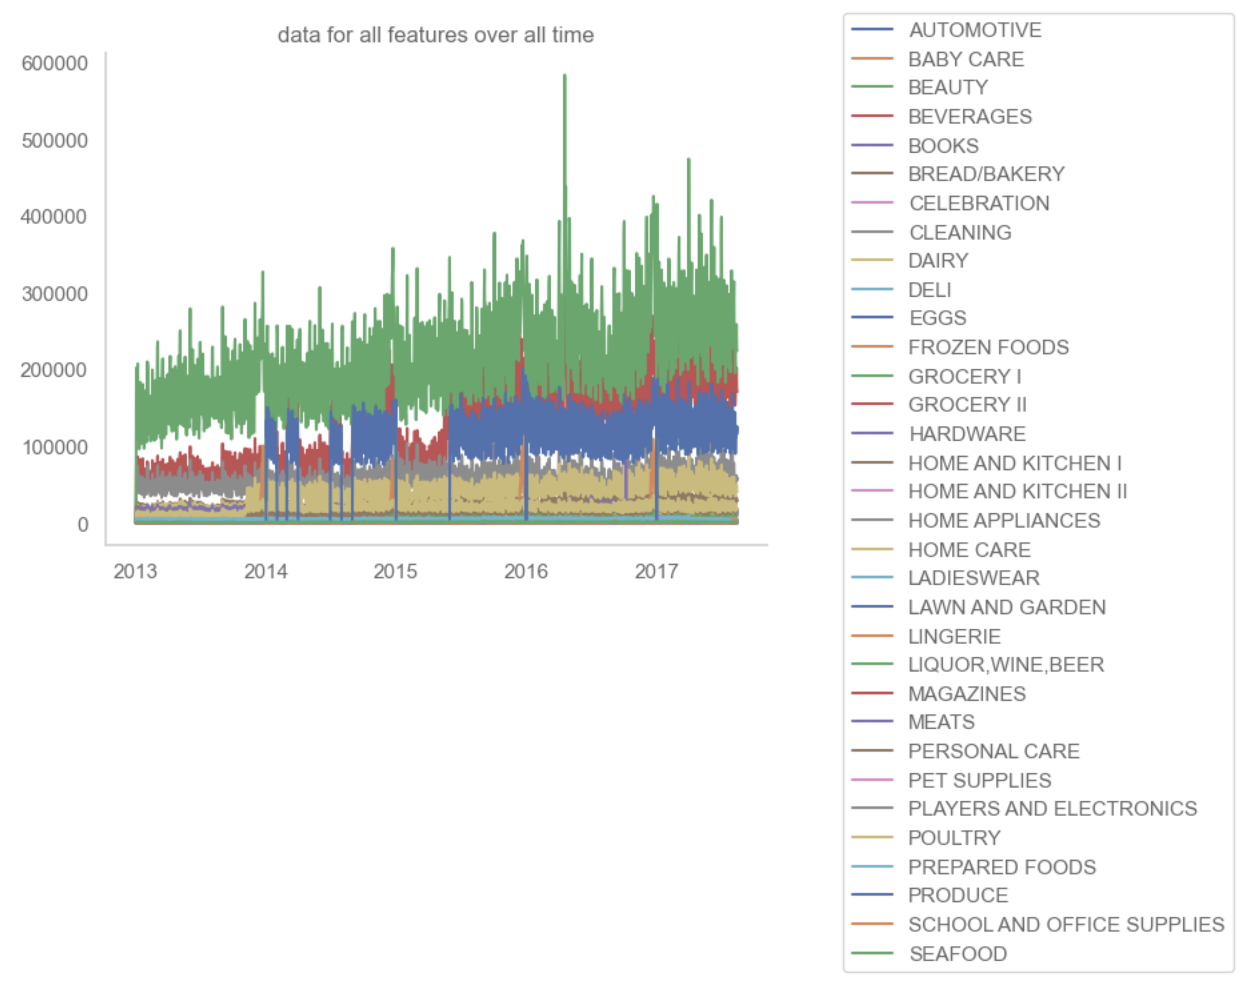

In [12]:
total_sales_df = agg_df.pivot(index='date',columns='family', values='sales')
total_sales_df.head()

family,BREAD/BAKERY,DAIRY,DELI,FROZEN FOODS,GROCERY I
date,,,,,
2013-01-01,180.59,143.00,71.09,29.65,700.00
2013-01-02,26246.32,23381.00,15754.50,7115.39,202020.00
2013-01-03,18456.48,18001.00,11172.45,4760.81,144878.00
2013-01-04,16721.97,18148.00,10143.21,4525.93,135754.00
2013-01-05,22367.76,23082.00,13734.95,5781.61,188356.00


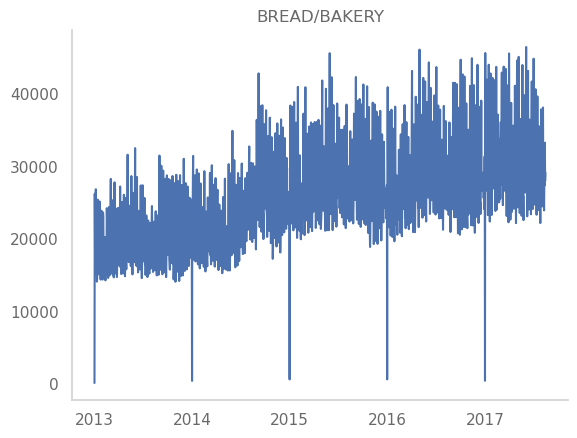

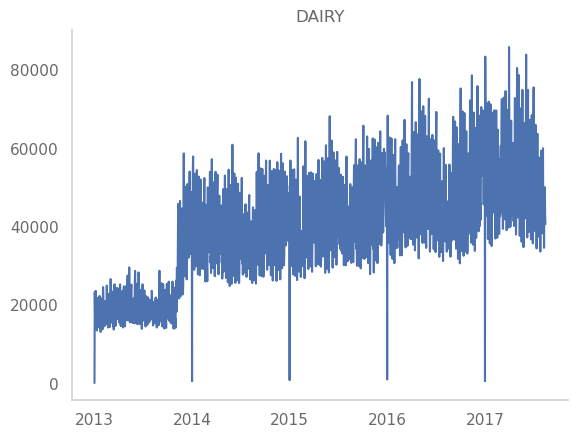

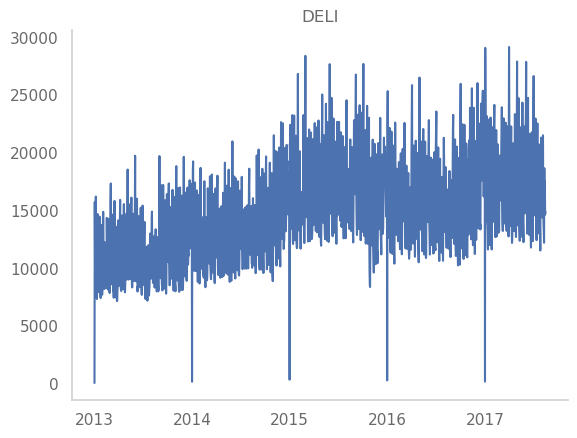

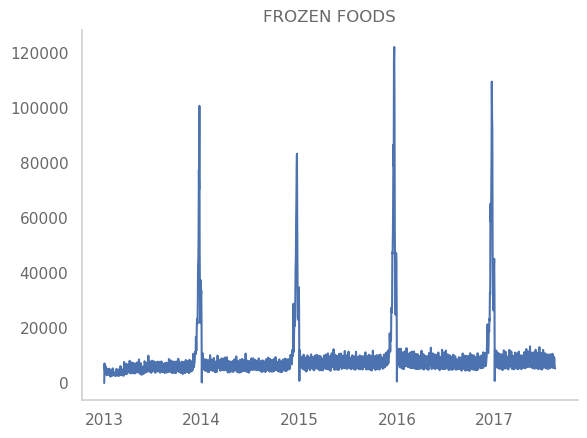

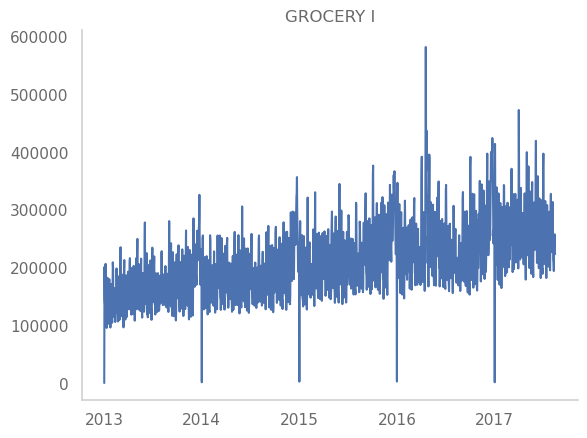

In [13]:
plt.rcParams['font.family'] = 'sans-serif' 
for column in total_sales_df.columns:
    plt.plot(total_sales_df[column])
    plt.title(column)
    plt.show()

In [14]:
total_sales_df = total_sales_df[total_sales_df.index>='2015-08-15']

In [15]:
missing_data(total_sales_df).head()

,Total,Percent,Types
family,,,
BREAD/BAKERY,0,0.00,float64
DAIRY,0,0.00,float64
DELI,0,0.00,float64
FROZEN FOODS,0,0.00,float64
GROCERY I,0,0.00,float64


### DATA CLEANING REQUIREMENTS
1. Remove low-volume data that can't be predicted.
2. Remove situations where there's not enough data. (i.e. by visual inspection or by number of '0' daily sales counts.
3. Remove outliers (automated by calculating z-score and just removing it and having Prophet impute those values). This will remove the outliers near 0 for all categories.
4. Check if more data needs to be removed after filtering to 08/15/15 - 08/15/17. If not, then we can move throughout the pipeline.

In [16]:
old_len = len(total_sales_df.columns)

#Keep categories with avg daily sales greater than $1000
total_sales_df = total_sales_df[total_sales_df.columns[total_sales_df.apply(np.mean,axis='rows') > 1000]]

print("Dropping "+ str(old_len-len(total_sales_df.columns))+" columns due to insufficient data volume.")

Dropping 0 columns due to insufficient data volume.


In [17]:
#Get percentage of rows for each category that is at 0

(total_sales_df == 0).astype(int).sum(axis=0)/len(total_sales_df.sum(axis=0))

family
BREAD/BAKERY   0.00
DAIRY          0.00
DELI           0.00
FROZEN FOODS   0.00
GROCERY I      0.00
dtype: float64

After checking for 0s and not seeing any issues, we can keep all the categories that we have left in the dataframe.

In [18]:
print(total_sales_df.columns)

Index(['BREAD/BAKERY', 'DAIRY', 'DELI', 'FROZEN FOODS', 'GROCERY I'], dtype='object', name='family')


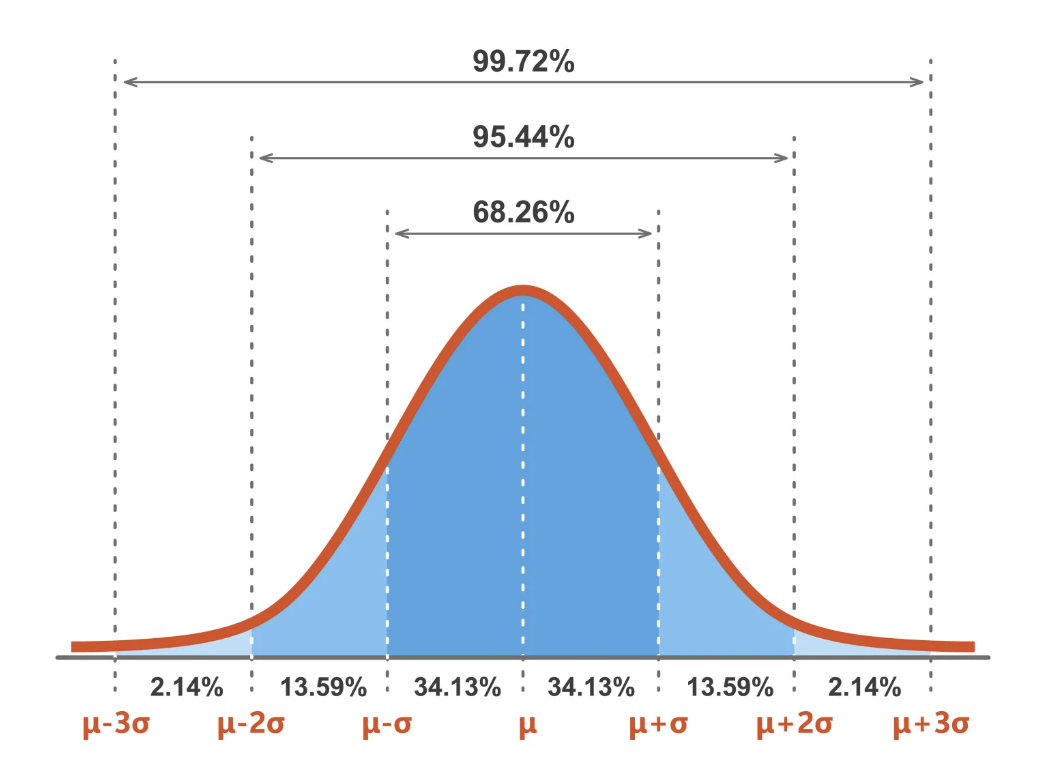

In [19]:
#Need to break out each into it's own dataframe for prediction since each will have different rows affected
prediction_df_list = []

#Cleaning up dataframe using z-score to remove outliers which heavily bias the model
for column in total_sales_df.columns:
    df_clean = total_sales_df[[column]].reset_index()
    
    z = np.abs(stats.zscore(df_clean[column]))
    outlier_index = np.where(z > 2.7)[0] #As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_clean.drop(index=outlier_index,inplace=True)
    df_clean.set_index('date', inplace=True)
    prediction_df_list.append(df_clean)

Dropping 11 rows for following category: BREAD/BAKERY
Dropping 10 rows for following category: DAIRY
Dropping 9 rows for following category: DELI
Dropping 22 rows for following category: FROZEN FOODS
Dropping 11 rows for following category: GROCERY I


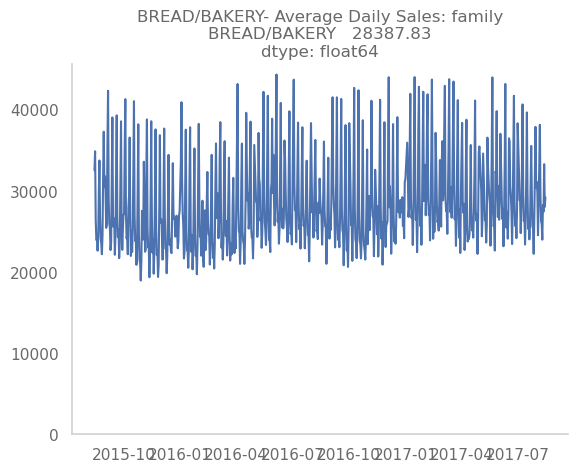

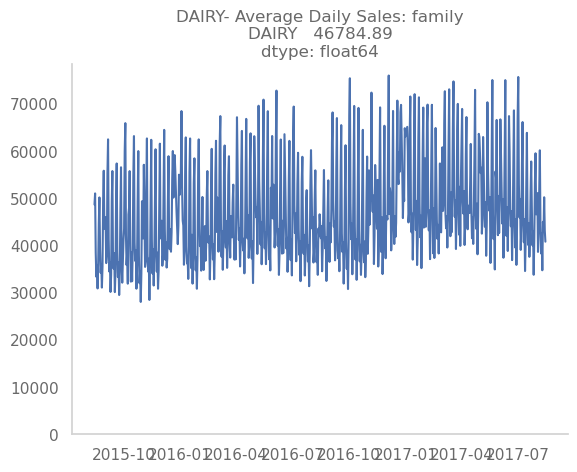

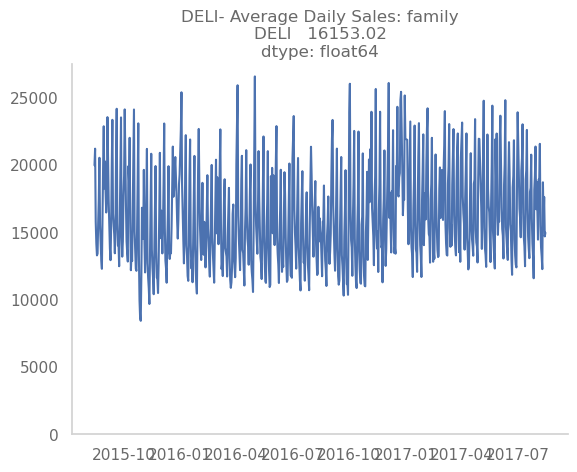

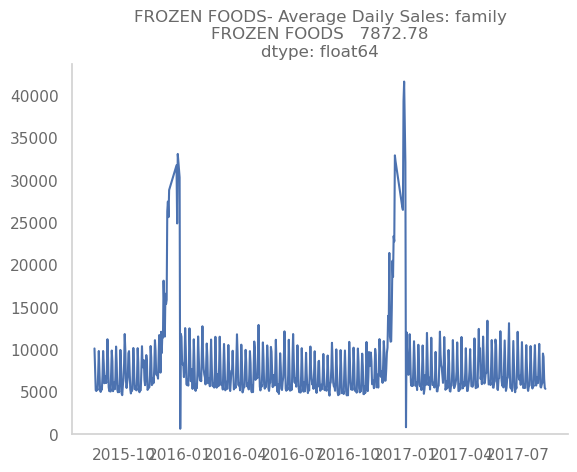

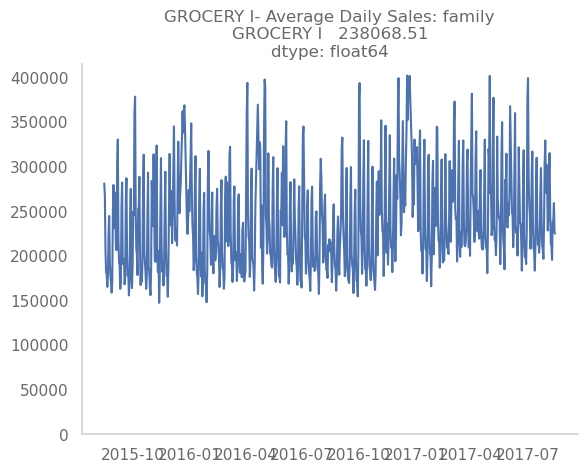

In [20]:
for i in range(len(prediction_df_list)):
    plt.plot(prediction_df_list[i])
    plt.title(prediction_df_list[i].columns[0]+'- Average Daily Sales: '+str(prediction_df_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

For further hypertuning, things to adjust would be on the category level. I'm not going to do further hypertuning in this notebook but here are the following things you can test and adjust to determine whether it's a category that can be predicted given the data.

1. Impute or drop situations for the <b>Liquor, Beer, Wine category</b> since there are many 0s in the first years worth of data. See if it improves the MAPE after cross-validation.
2. Impute or drop situations for the <b>Grocery II and Frozen Food categories </b> since there are 0s near the January 1st beginning of the year timeline that didn't get dropped during the z-score outlier automation. See if it improves the MAPE after cross-validation.
3. <b>Adjust the z-score outlier parameter</b> by checking out the Gaussian Distribution for different z-scores, check cut-offs and counts of rows being dropped, and see if there's an ideal situation for getting the best MAPE. (Idea is to loop through possible z-score possibilies, perhaps between 5 linear possibilities between 2.5 --> 3 and run the models with the best hypertuned parameters based on cross-validation below to see if MAPE's change with a change in z-score outlier drops.

### PLOTTING CATEGORIES

In [21]:
#lets break it down by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(),[33,66])

In [22]:
low_vol_columns = avg_daily_sales[avg_daily_sales<=low].index.tolist()
mid_vol_columns = avg_daily_sales[(avg_daily_sales>low) & (avg_daily_sales<mid)].index
high_vol_columns = avg_daily_sales[avg_daily_sales>=mid].index

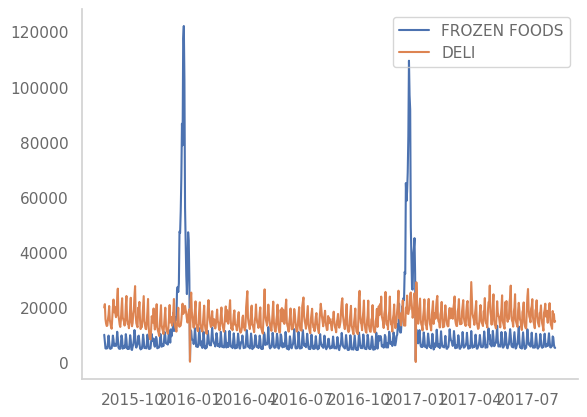

In [23]:
#total_sales_df[low_vol_columns].plot.line()
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc='best') #, bbox_to_anchor=(1.1, 1.1))
plt.show()

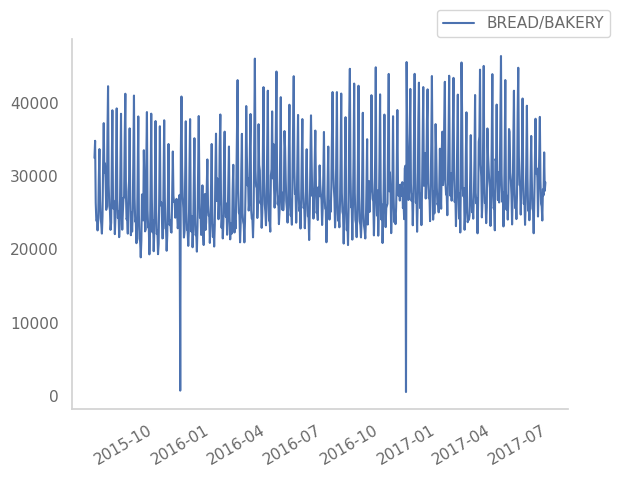

In [24]:
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

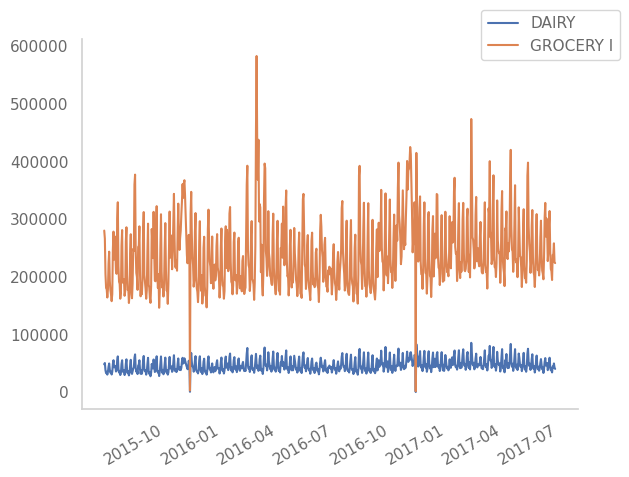

In [25]:
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

### HYPERPARAMETER TUNING AND BACKTESTING PIPELINE

Ranges give on Prophet's documentation

1. changepoint_prior_scale [0.001, 0.5] 
2. seasonality_prior_scale [0.01, 10]
3. holidays_prior_scale [0.01, 10] 
4. seasonality_mode ['additive', 'multiplicative'].
5. changepoint_range [0.5, 0.95]

https://facebook.github.io/prophet/docs/diagnostics.html

In [26]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [27]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

#seasonality_mode_options = ['additive', 'multiplicative']
#changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

In [28]:
start_time = time.time()

dicts = {}

for feature in total_sales_df.columns:
  
    category_df = total_sales_df[feature].copy().reset_index()
    category_df.columns = ["ds", "y"]

    category_df[["y"]] = category_df[["y"]].apply(pd.to_numeric)
    category_df["ds"] = pd.to_datetime(category_df["ds"])
    
    param_grid = {  
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range }
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = [] 

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params).fit(category_df)  # Fit model with given params
        df_cv = cross_validation(m, initial="365 days", period="30 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        print(df_p)
        mapes.append(df_p["mape"].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results["mape"] = mapes
    
    print(feature)
    print(tuning_results.head())

    params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
    params_dict["column"] = feature 
    
    dicts[feature] = params_dict

print("--- %s seconds ---" % (time.time() - start_time)) #about 18 minutes

10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start processing
10:49:40 - cmdstanpy - INFO - Chain [1] done processing
10:49:40 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17976794.82 4239.91 2857.00  0.29   0.07   0.10      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:42 - cmdstanpy - INFO - Chain [1] done processing
10:49:42 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:49:42 - cmdstanpy - INFO - Chain [1] start processing
10:49:43 - cmdstanpy - INFO - Chain [1] done processing
10:49:43 - cmdstanpy - INFO - Chain [1] start processing
10:49:43 - cmdstanpy - INFO - Chain [1] done processing
10:49:43 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18773932.90 4332.89 3027.96  0.30   0.08   0.11      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:44 - cmdstanpy - INFO - Chain [1] done processing
10:49:44 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:49:44 - cmdstanpy - INFO - Chain [1] start processing
10:49:45 - cmdstanpy - INFO - Chain [1] done processing
10:49:45 - cmdstanpy - INFO - Chain [1] start processing
10:49:45 - cmdstanpy - INFO - Chain [1] done processing
10:49:45 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19900030.50 4460.95 3140.26  0.31   0.09   0.11      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:46 - cmdstanpy - INFO - Chain [1] done processing
10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:46 - cmdstanpy - INFO - Chain [1] done processing
10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:46 - cmdstanpy - INFO - Chain [1] done processing
10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:46 - cmdstanpy - INFO - Chain [1] done processing
10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:46 - cmdstanpy - INFO - Chain [1] done processing
10:49:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:49:46 - cmdstanpy - INFO - Chain [1] start processing
10:49:47 - cmdstanpy - INFO - Chain [1] done processing
10:49:47 - cmdstanpy - INFO - Chain [1] start processing
10:49:47 - cmdstanpy - INFO - Chain [1] done processing
10:49:47 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19739638.00 4442.93 3084.57  0.31   0.08   0.11      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing
10:49:49 - cmdstanpy - INFO - Chain [1] start processing
10:49:49 - cmdstanpy - INFO - Chain [1] done processing
10:49:49 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 22889293.96 4784.28 3399.21  0.32   0.09   0.12      0.69


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1] done processing
10:49:50 - cmdstanpy - INFO - Chain [1] start processing
10:49:50 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14436364.92 3799.52 2577.15  0.29   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14762150.51 3842.15 2509.33  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:51 - cmdstanpy - INFO - Chain [1] start processing
10:49:51 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14776586.97 3844.03 2515.58  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1] done processing
10:49:52 - cmdstanpy - INFO - Chain [1] start processing
10:49:52 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14782893.09 3844.85 2516.09  0.30   0.07   0.09      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14749159.88 3840.46 2505.38  0.30   0.06   0.09      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:53 - cmdstanpy - INFO - Chain [1] start processing
10:49:53 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14062510.98 3750.00 2480.38  0.29   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:54 - cmdstanpy - INFO - Chain [1] start processing
10:49:54 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14509345.73 3809.11 2447.73  0.30   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1] done processing
10:49:55 - cmdstanpy - INFO - Chain [1] start processing
10:49:55 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14510782.14 3809.30 2449.99  0.30   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing
10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14541161.58 3813.29 2451.09  0.30   0.07   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1] done processing
10:49:57 - cmdstanpy - INFO - Chain [1] start processing
10:49:57 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14446350.70 3800.84 2440.12  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13835454.50 3719.60 2428.64  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:58 - cmdstanpy - INFO - Chain [1] start processing
10:49:58 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14422874.89 3797.75 2428.77  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:49:59 - cmdstanpy - INFO - Chain [1] done processing
10:49:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14386717.23 3792.98 2421.94  0.30   0.06   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1] done processing
10:50:00 - cmdstanpy - INFO - Chain [1] start processing
10:50:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14422462.64 3797.69 2428.40  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1] done processing
10:50:01 - cmdstanpy - INFO - Chain [1] start processing
10:50:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14437421.01 3799.66 2429.22  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 13727130.96 3705.01 2400.31  0.29   0.07   0.08      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:02 - cmdstanpy - INFO - Chain [1] start processing
10:50:02 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14310322.26 3782.90 2397.11  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:03 - cmdstanpy - INFO - Chain [1] done processing
10:50:03 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14321679.95 3784.40 2398.38  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:04 - cmdstanpy - INFO - Chain [1] start processing
10:50:04 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14335355.81 3786.21 2402.88  0.30   0.06   0.08      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1] done processing
10:50:05 - cmdstanpy - INFO - Chain [1] start processing
10:50:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 14325954.22 3784.96 2398.77  0.30   0.06   0.08      0.82
BREAD/BAKERY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.29
1                     0.00                     2.51  0.30
2                     0.00                     5.00  0.31
3                     0.00                     7.50  0.31
4                     0.00                    10.00  0.32


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start processing
10:50:06 - cmdstanpy - INFO - Chain [1] done processing
10:50:06 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 67340543.39 8206.13 5413.76  0.38   0.08   0.11      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:07 - cmdstanpy - INFO - Chain [1] done processing
10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:07 - cmdstanpy - INFO - Chain [1] done processing
10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:07 - cmdstanpy - INFO - Chain [1] done processing
10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:07 - cmdstanpy - INFO - Chain [1] done processing
10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:07 - cmdstanpy - INFO - Chain [1] done processing
10:50:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:07 - cmdstanpy - INFO - Chain [1] start processing
10:50:08 - cmdstanpy - INFO - Chain [1] done processing
10:50:08 - cmdstanpy - INFO - Chain [1] start processing
10:50:08 - cmdstanpy - INFO - Chain [1] done processing
10:50:08 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75520375.59 8690.25 6024.69  0.41   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:08 - cmdstanpy - INFO - Chain [1] start processing
10:50:08 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start processing
10:50:09 - cmdstanpy - INFO - Chain [1] done processing
10:50:09 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 73107270.00 8550.28 5895.98  0.41   0.09   0.12      0.76


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start processing
10:50:10 - cmdstanpy - INFO - Chain [1] done processing
10:50:10 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75458306.46 8686.67 6083.01  0.41   0.10   0.13      0.75


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:11 - cmdstanpy - INFO - Chain [1] done processing
10:50:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:11 - cmdstanpy - INFO - Chain [1] start processing
10:50:12 - cmdstanpy - INFO - Chain [1] done processing
10:50:12 - cmdstanpy - INFO - Chain [1] start processing
10:50:12 - cmdstanpy - INFO - Chain [1] done processing
10:50:12 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 71765118.79 8471.43 5808.63  0.41   0.09   0.12      0.77


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:12 - cmdstanpy - INFO - Chain [1] start processing
10:50:12 - cmdstanpy - INFO - Chain [1] done processing
10:50:12 - cmdstanpy - INFO - Chain [1] start processing
10:50:12 - cmdstanpy - INFO - Chain [1] done processing
10:50:12 - cmdstanpy - INFO - Chain [1] start processing
10:50:12 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51851980.00 7200.83 4859.12  0.38   0.08   0.10      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1] done processing
10:50:13 - cmdstanpy - INFO - Chain [1] start processing
10:50:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48018570.09 6929.54 4408.87  0.38   0.07   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47950207.62 6924.61 4398.60  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:14 - cmdstanpy - INFO - Chain [1] start processing
10:50:14 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47959483.95 6925.28 4404.31  0.38   0.07   0.09      0.87


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:15 - cmdstanpy - INFO - Chain [1] start processing
10:50:15 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 48004505.34 6928.53 4403.31  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1] done processing
10:50:16 - cmdstanpy - INFO - Chain [1] start processing
10:50:16 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52161759.81 7222.31 4801.73  0.38   0.07   0.10      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47665408.94 6904.01 4328.74  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:17 - cmdstanpy - INFO - Chain [1] done processing
10:50:17 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47585350.47 6898.21 4327.70  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1] done processing
10:50:18 - cmdstanpy - INFO - Chain [1] start processing
10:50:18 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47603095.24 6899.50 4324.65  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:19 - cmdstanpy - INFO - Chain [1] start processing
10:50:19 - cmdstanpy - INFO - Chain [1] done processing
10:50:19 - cmdstanpy - INFO - Chain [1] start processing
10:50:19 - cmdstanpy - INFO - Chain [1] done processing
10:50:19 - cmdstanpy - INFO - Chain [1] start processing
10:50:19 - cmdstanpy - INFO - Chain [1] done processing
10:50:19 - cmdstanpy - INFO - Chain [1] start processing
10:50:19 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47585915.46 6898.25 4323.91  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1] done processing
10:50:20 - cmdstanpy - INFO - Chain [1] start processing
10:50:20 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52615407.54 7253.65 4835.58  0.38   0.07   0.10      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1] done processing
10:50:21 - cmdstanpy - INFO - Chain [1] start processing
10:50:21 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47607977.44 6899.85 4302.97  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47633411.11 6901.70 4309.39  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:22 - cmdstanpy - INFO - Chain [1] start processing
10:50:22 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47623687.61 6900.99 4299.27  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1] done processing
10:50:23 - cmdstanpy - INFO - Chain [1] start processing
10:50:23 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47615116.47 6900.37 4309.61  0.38   0.07   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52434079.28 7241.14 4810.55  0.38   0.07   0.10      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:24 - cmdstanpy - INFO - Chain [1] start processing
10:50:24 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47733081.97 6908.91 4290.31  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47760724.29 6910.91 4294.56  0.38   0.06   0.09      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1] done processing
10:50:26 - cmdstanpy - INFO - Chain [1] start processing
10:50:26 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47821775.12 6915.33 4293.42  0.38   0.06   0.09      0.85


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47809081.26 6914.41 4298.14  0.38   0.06   0.09      0.86
DAIRY
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.38
1                     0.00                     2.51  0.41
2                     0.00                     5.00  0.41
3                     0.00                     7.50  0.41
4                     0.00                    10.00  0.41


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:27 - cmdstanpy - INFO - Chain [1] start processing
10:50:27 - cmdstanpy - INFO - Chain [1] done processing
10:50:28 - cmdstanpy - INFO - Chain [1] start processing
10:50:28 - cmdstanpy - INFO - Chain [1] done processing
10:50:28 - cmdstanpy - INFO - Chain [1] start processing
10:50:28 - cmdstanpy - INFO - Chain [1] done processing
10:50:28 - cmdstanpy - INFO - Chain [1] start processing
10:50:28 - cmdstanpy - INFO - Chain [1] done processing
10:50:28 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:28 - cmdstanpy - INFO - Chain [1] start processing
10:50:28 - cmdstanpy - INFO - Chain [1] done processing
10:50:28 - cmdstanpy - INFO - Chain [1] start processing
10:50:28 - cmdstanpy - INFO - Chain [1] done processing
10:50:28 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 17819797.21 4221.35 3167.10  0.46   0.15   0.20      0.65


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - INFO - Chain [1] start processing
10:50:30 - cmdstanpy - INFO - Chain [1] done processing
10:50:30 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18346115.09 4283.24 3210.42  0.49   0.15   0.22      0.63


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:31 - cmdstanpy - INFO - Chain [1] start processing
10:50:31 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start processing
10:50:32 - cmdstanpy - INFO - Chain [1] done processing
10:50:32 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 19330302.64 4396.62 3351.88  0.50   0.17   0.23      0.58


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:33 - cmdstanpy - INFO - Chain [1] start processing
10:50:33 - cmdstanpy - INFO - Chain [1] done processing
10:50:33 - cmdstanpy - INFO - Chain [1] start processing
10:50:33 - cmdstanpy - INFO - Chain [1] done processing
10:50:33 - cmdstanpy - INFO - Chain [1] start processing
10:50:33 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:34 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - INFO - Chain [1] start processing
10:50:34 - cmdstanpy - INFO - Chain [1] done processing
10:50:34 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18443643.83 4294.61 3214.44  0.49   0.15   0.22      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:35 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:35 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:35 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:35 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:35 - cmdstanpy - INFO - Chain [1] done processing
10:50:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:35 - cmdstanpy - INFO - Chain [1] start processing
10:50:36 - cmdstanpy - INFO - Chain [1] done processing
10:50:36 - cmdstanpy - INFO - Chain [1] start processing
10:50:36 - cmdstanpy - INFO - Chain [1] done processing
10:50:36 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 18154656.01 4260.83 3164.77  0.49   0.15   0.22      0.60


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:37 - cmdstanpy - INFO - Chain [1] done processing
10:50:37 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7752703.66 2784.37 1935.42  0.44   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1] done processing
10:50:38 - cmdstanpy - INFO - Chain [1] start processing
10:50:38 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7972873.62 2823.63 1863.93  0.45   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1] done processing
10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:39 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7991941.37 2827.00 1863.78  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:39 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8037314.89 2835.02 1884.89  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:40 - cmdstanpy - INFO - Chain [1] start processing
10:50:40 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7981526.33 2825.16 1868.15  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1] done processing
10:50:41 - cmdstanpy - INFO - Chain [1] start processing
10:50:41 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7699646.17 2774.82 1910.10  0.44   0.10   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8041285.69 2835.72 1874.89  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8053025.55 2837.79 1877.50  0.46   0.08   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:43 - cmdstanpy - INFO - Chain [1] done processing
10:50:43 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8053035.96 2837.79 1878.30  0.46   0.09   0.11      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:44 - cmdstanpy - INFO - Chain [1] done processing
10:50:44 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8030788.69 2833.86 1873.17  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:45 - cmdstanpy - INFO - Chain [1] start processing
10:50:45 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7739544.60 2782.00 1910.80  0.44   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1] done processing
10:50:46 - cmdstanpy - INFO - Chain [1] start processing
10:50:46 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8047514.35 2836.81 1873.08  0.46   0.09   0.11      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1] done processing
10:50:47 - cmdstanpy - INFO - Chain [1] start processing
10:50:47 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8084664.58 2843.35 1884.07  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8094600.81 2845.10 1885.12  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:48 - cmdstanpy - INFO - Chain [1] start processing
10:50:48 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8079183.87 2842.39 1881.01  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:49 - cmdstanpy - INFO - Chain [1] start processing
10:50:49 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 7710187.04 2776.72 1903.80  0.44   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:50 - cmdstanpy - INFO - Chain [1] done processing
10:50:50 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8232815.17 2869.29 1909.45  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:51 - cmdstanpy - INFO - Chain [1] done processing
10:50:51 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8184616.38 2860.88 1899.01  0.46   0.09   0.12      0.81


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1] done processing
10:50:52 - cmdstanpy - INFO - Chain [1] start processing
10:50:52 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8212173.41 2865.69 1902.63  0.46   0.09   0.12      0.80


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1] done processing
10:50:53 - cmdstanpy - INFO - Chain [1] start processing
10:50:53 - cmdstanpy - INFO - Chain [1]

  horizon        mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 8216105.69 2866.38 1905.30  0.46   0.09   0.12      0.81
DELI
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.46
1                     0.00                     2.51  0.49
2                     0.00                     5.00  0.50
3                     0.00                     7.50  0.49
4                     0.00                    10.00  0.49


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:54 - cmdstanpy - INFO - Chain [1] start processing
10:50:54 - cmdstanpy - INFO - Chain [1] done processing
10:50:54 - cmdstanpy - INFO - Chain [1] start processing
10:50:54 - cmdstanpy - INFO - Chain [1] done processing
10:50:54 - cmdstanpy - INFO - Chain [1] start processing
10:50:54 - cmdstanpy - INFO - Chain [1] done processing
10:50:54 - cmdstanpy - INFO - Chain [1] start processing
10:50:54 - cmdstanpy - INFO - Chain [1] done processing
10:50:54 - cmdstanpy - INFO - Chain [1] start processing
10:50:54 - cmdstanpy - INFO - Chain [1] done processing
10:50:54 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:54 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 47078374.35 6861.37 3639.26  0.47   0.32   0.44      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:55 - cmdstanpy - INFO - Chain [1] done processing
10:50:55 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:55 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53252864.51 7297.46 4211.48  0.56   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:56 - cmdstanpy - INFO - Chain [1] start processing
10:50:56 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53012045.65 7280.94 4170.86  0.55   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start processing
10:50:57 - cmdstanpy - INFO - Chain [1] done processing
10:50:57 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51003890.24 7141.70 4126.72  0.55   0.37   0.56      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - INFO - Chain [1] start processing
10:50:58 - cmdstanpy - INFO - Chain [1] done processing
10:50:58 - cmdstanpy - INFO - Chain [1] start process

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53340958.24 7303.49 4226.48  0.56   0.37   0.57      0.94


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53163287.81 7291.32 4036.36  0.53   0.32   0.46      0.93


  0%|          | 0/12 [00:00<?, ?it/s]

10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49507227.98 7036.14 3802.05  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:00 - cmdstanpy - INFO - Chain [1] done processing
10:51:00 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49565358.50 7040.27 3802.33  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49545831.57 7038.88 3797.37  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:01 - cmdstanpy - INFO - Chain [1] done processing
10:51:01 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49501405.24 7035.72 3798.95  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:02 - cmdstanpy - INFO - Chain [1] done processing
10:51:02 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 59363895.11 7704.80 4388.91  0.58   0.36   0.46      0.89


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1] done processing
10:51:03 - cmdstanpy - INFO - Chain [1] start processing
10:51:03 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 49995637.02 7070.76 3806.76  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50075534.67 7076.41 3807.28  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:04 - cmdstanpy - INFO - Chain [1] start processing
10:51:04 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50057643.71 7075.14 3809.56  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1] done processing
10:51:05 - cmdstanpy - INFO - Chain [1] start processing
10:51:05 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 50159802.29 7082.36 3815.43  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1] done processing
10:51:06 - cmdstanpy - INFO - Chain [1] start processing
10:51:06 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 65631160.63 8101.31 4741.07  0.63   0.37   0.51      0.86


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1] done processing
10:51:07 - cmdstanpy - INFO - Chain [1] start processing
10:51:07 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51988335.61 7210.29 3847.19  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 51975579.30 7209.41 3845.41  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:08 - cmdstanpy - INFO - Chain [1] start processing
10:51:08 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52287737.61 7231.03 3849.72  0.50   0.32   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1] done processing
10:51:09 - cmdstanpy - INFO - Chain [1] start processing
10:51:09 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 52637242.96 7255.15 3855.28  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:10 - cmdstanpy - INFO - Chain [1] start processing
10:51:10 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 75294982.80 8677.27 4895.33  0.65   0.34   0.51      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1] done processing
10:51:11 - cmdstanpy - INFO - Chain [1] start processing
10:51:11 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54297268.55 7368.67 3897.82  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 54885094.44 7408.45 3907.93  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:12 - cmdstanpy - INFO - Chain [1] start processing
10:51:12 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53980467.89 7347.14 3890.28  0.50   0.33   0.42      0.92


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:13 - cmdstanpy - INFO - Chain [1] start processing
10:51:13 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1]

  horizon         mse    rmse     mae  mape  mdape  smape  coverage
0 30 days 53859325.25 7338.89 3893.35  0.50   0.33   0.42      0.92
FROZEN FOODS
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.47
1                     0.00                     2.51  0.56
2                     0.00                     5.00  0.55
3                     0.00                     7.50  0.55
4                     0.00                    10.00  0.56


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start processing
10:51:14 - cmdstanpy - INFO - Chain [1] done processing
10:51:14 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3072490023.02 55430.05 40605.68  0.59   0.13   0.17      0.71


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start processing
10:51:15 - cmdstanpy - INFO - Chain [1] done processing
10:51:15 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3576652303.38 59805.12 46370.42  0.64   0.15   0.20      0.70


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - INFO - Chain [1] start processing
10:51:16 - cmdstanpy - INFO - Chain [1] done processing
10:51:16 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3545207191.48 59541.64 46061.79  0.63   0.16   0.20      0.72


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start processing
10:51:17 - cmdstanpy - INFO - Chain [1] done processing
10:51:17 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3483960404.34 59025.08 45256.18  0.63   0.15   0.20      0.74


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start processing
10:51:18 - cmdstanpy - INFO - Chain [1] done processing
10:51:18 - cmdstanpy - INFO - Chain [1] start process

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 3446131079.44 58703.76 44751.41  0.63   0.15   0.20      0.73


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1] done processing
10:51:19 - cmdstanpy - INFO - Chain [1] start processing
10:51:19 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1946450382.13 44118.59 30168.48  0.57   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1950789529.56 44167.74 29480.14  0.57   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:20 - cmdstanpy - INFO - Chain [1] start processing
10:51:20 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1941028748.75 44057.11 29377.68  0.57   0.08   0.11      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1] done processing
10:51:21 - cmdstanpy - INFO - Chain [1] start processing
10:51:21 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1948232007.40 44138.78 29449.34  0.57   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1942966094.60 44079.09 29418.16  0.57   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:22 - cmdstanpy - INFO - Chain [1] start processing
10:51:22 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1995070364.48 44666.21 30540.64  0.57   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:23 - cmdstanpy - INFO - Chain [1] start processing
10:51:23 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1952903163.67 44191.66 29752.87  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1] done processing
10:51:24 - cmdstanpy - INFO - Chain [1] start processing
10:51:24 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953441104.69 44197.75 29756.93  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1954995166.97 44215.33 29775.23  0.58   0.08   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:25 - cmdstanpy - INFO - Chain [1] done processing
10:51:25 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1952342428.43 44185.32 29740.36  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:26 - cmdstanpy - INFO - Chain [1] start processing
10:51:26 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1980455876.87 44502.31 30486.21  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1] done processing
10:51:27 - cmdstanpy - INFO - Chain [1] start processing
10:51:27 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1951220855.56 44172.63 29844.33  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1] done processing
10:51:28 - cmdstanpy - INFO - Chain [1] start processing
10:51:28 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1953482553.65 44198.22 29864.11  0.58   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1946933705.36 44124.07 29763.45  0.58   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:29 - cmdstanpy - INFO - Chain [1] start processing
10:51:29 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1950655337.45 44166.22 29816.28  0.59   0.09   0.12      0.84


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:30 - cmdstanpy - INFO - Chain [1] done processing
10:51:30 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1963690426.03 44313.55 30366.82  0.58   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1] done processing
10:51:31 - cmdstanpy - INFO - Chain [1] start processing
10:51:31 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1940756463.51 44054.02 29904.27  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1] done processing
10:51:32 - cmdstanpy - INFO - Chain [1] start processing
10:51:32 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1941830557.04 44066.21 29957.26  0.59   0.09   0.12      0.83


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1934274902.15 43980.39 29869.52  0.59   0.09   0.12      0.82


  0%|          | 0/12 [00:00<?, ?it/s]

10:51:33 - cmdstanpy - INFO - Chain [1] start processing
10:51:33 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1] done processing
10:51:34 - cmdstanpy - INFO - Chain [1] start processing
10:51:34 - cmdstanpy - INFO - Chain [1]

  horizon           mse     rmse      mae  mape  mdape  smape  coverage
0 30 days 1937878352.44 44021.34 29876.97  0.59   0.09   0.12      0.83
GROCERY I
   changepoint_prior_scale  seasonality_prior_scale  mape
0                     0.00                     0.01  0.59
1                     0.00                     2.51  0.64
2                     0.00                     5.00  0.63
3                     0.00                     7.50  0.63
4                     0.00                    10.00  0.63
--- 114.64624834060669 seconds ---


In [29]:
#how to call params_dict for a feature

dicts

{'BREAD/BAKERY': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.2859368891771825,
  'column': 'BREAD/BAKERY'},
 'DAIRY': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.38014565593198163,
  'column': 'DAIRY'},
 'DELI': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4372770190398254,
  'column': 'DELI'},
 'FROZEN FOODS': {'changepoint_prior_scale': 0.001,
  'seasonality_prior_scale': 0.01,
  'mape': 0.4694668248711002,
  'column': 'FROZEN FOODS'},
 'GROCERY I': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.5673620593673331,
  'column': 'GROCERY I'}}

### HOLIDAY DATA

In [30]:
#adding holiday data

holiday = pd.DataFrame([])

ecuador_holidays = holidays.EC()  # this is a dict
# the below is the same, but takes a string:
ecuador_holidays = holidays.country_holidays('EC')  # this is a dict


for date_, name in sorted(holidays.EC(years=[2015,2016,2017,2018]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "EC-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True) 

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

,ds,holiday,lower_window,upper_window
0,2015-01-01,EC-Holidays,-2,1
1,2015-02-16,EC-Holidays,-2,1
2,2015-02-17,EC-Holidays,-2,1
3,2015-04-03,EC-Holidays,-2,1
4,2015-05-01,EC-Holidays,-2,1


https://pypi.org/project/holidays/

### BACKTESTING WITH TUNED METRICS LATEST MONTH UP-TO-DATE MAPE

In [31]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index) - timedelta(prediction_days)

[Timeseries From Scratch article](https://towardsdatascience.com/time-series-from-scratch-decomposing-time-series-data-7b7ad0c30fe7#:~:text=a%20single%20season.-,Multiplicative%20trend%20and%20additive%20seasonality,of%20seasonal%20periods%20over%20time.&text=You%20can%20see%20how%20the%20trend%20is%20slightly%20curved.) will show you the breakdown of the different ways to identify and configure time series parameters for the data you have/business needs utilizing your data.

In [32]:
#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                #changepoint_range= len(df_copy/365),
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    filter = fcst_prophet_train['ds']>=forecast_start_date 
    predicted_df = fcst_prophet_train[filter][['ds','yhat']]
    predicted_df = predicted_df.merge(df_copy)

    print(feature,mape(predicted_df['y'],predicted_df['yhat']))

10:52:23 - cmdstanpy - INFO - Chain [1] start processing
10:52:23 - cmdstanpy - INFO - Chain [1] done processing
10:52:24 - cmdstanpy - INFO - Chain [1] start processing
10:52:24 - cmdstanpy - INFO - Chain [1] done processing
10:52:24 - cmdstanpy - INFO - Chain [1] start processing


BREAD/BAKERY 7.538128605216013
DAIRY 14.542060144709106


10:52:24 - cmdstanpy - INFO - Chain [1] done processing
10:52:24 - cmdstanpy - INFO - Chain [1] start processing
10:52:24 - cmdstanpy - INFO - Chain [1] done processing
10:52:24 - cmdstanpy - INFO - Chain [1] start processing
10:52:24 - cmdstanpy - INFO - Chain [1] done processing


DELI 12.080990011588398
FROZEN FOODS 48.3941714154867
GROCERY I 11.282498997509565


### FINAL FORECASTING

In [33]:
prediction_days = 30
forecast_start_date = max(total_sales_df.index)
print(forecast_start_date)

2017-08-15 00:00:00


In [34]:
# List to store trained models
trained_models = []

for feature in total_sales_df.columns[:5]:
    
    # Formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    # Finding the right params_dict for this category
    params_dict = dicts[feature]
    
    # Model
    m = Prophet(changepoint_prior_scale=params_dict['changepoint_prior_scale'],
                seasonality_prior_scale=params_dict['seasonality_prior_scale'],
                seasonality_mode='multiplicative',
                holidays=holiday
               )
    
    m.fit(df_copy_)
    
    # Append trained model to the list
    trained_models.append(m)

# Save trained models to a file
with open('trained_prophet_models_favorita.pkl', 'wb') as f:
    pickle.dump(trained_models, f)

10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] done processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] done processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] done processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] done processing
10:52:35 - cmdstanpy - INFO - Chain [1] start processing
10:52:35 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
# Load trained models
trained_models = pd.read_pickle('trained_prophet_models_favorita.pkl')

forecasted_dfs = []

for m in trained_models:
    future = m.make_future_dataframe(periods=1)
    fcst_prophet_train = m.predict(future)
    plt.rcParams['font.family'] = 'sans-serif' 
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds'] >= forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)

In [40]:
# Print only the predicted sales data
for forecasted_df in forecasted_dfs:
    print(forecasted_df[['ds', 'yhat']])

            ds  yhat
0   2021-01-22 23.85
1   2021-01-28 23.94
2   2021-01-31 40.94
3   2021-02-01 27.28
4   2021-02-02 23.53
5   2021-02-06 33.01
6   2021-02-07 42.15
7   2021-02-09 24.22
8   2021-02-19 26.78
9   2021-02-21 44.56
10  2021-02-22 29.69
11  2021-02-23 25.59
12  2021-02-25 26.80
13  2021-02-26 27.51
14  2021-02-28 45.77
15  2021-03-01 30.49
16  2021-03-02 26.28
17  2021-03-04 27.51
18  2021-03-05 28.24
19  2021-03-06 36.81
20  2021-03-08 31.29
21  2021-03-09 26.97
22  2021-03-11 28.23
23  2021-03-12 28.97
24  2021-03-16 27.66
25  2021-03-18 28.94
26  2021-03-19 29.71
27  2021-03-20 38.71
28  2021-03-23 28.35
29  2021-03-25 29.66
30  2021-03-29 33.69
31  2021-03-30 29.03
32  2021-04-01 30.37
33  2021-04-02 31.17
34  2021-04-03 43.33
35  2021-04-04 58.90
36  2021-04-05 51.39
37  2021-04-06 33.37
38  2021-04-08 31.09
39  2021-04-14 30.39
40  2021-04-15 31.80
41  2021-04-16 32.63
42  2021-04-17 42.51
43  2021-04-19 36.10
44  2021-04-20 31.10
45  2021-04-22 32.52
46  2021-04-2

In [41]:
total_sales_df.columns

Index(['BREAD/BAKERY', 'DAIRY', 'DELI', 'FROZEN FOODS', 'GROCERY I'], dtype='object', name='family')

In [42]:
item_names = ['BREAD/BAKERY', 'DAIRY', 'DELI', 'FROZEN FOODS', 'GROCERY I']

# List to store data for the new DataFrame
data = []

# Iterate through forecasted_dfs
for i, forecasted_df in enumerate(forecasted_dfs):
    # Calculate the sum of yhat values
    total_sales = forecasted_df['yhat'].sum()
    # Get the item name based on index
    item_name = item_names[i]
    # Append data to the list
    data.append({"item": item_name, "total_sales": total_sales})

# Create DataFrame from the list
sales_df = pd.DataFrame(data)

print(sales_df)


           item  total_sales
0  BREAD/BAKERY     14402.18
1         DAIRY     15072.21
2          DELI      1745.61
3  FROZEN FOODS      1998.72
4     GROCERY I      3133.80


#PROPHET MODEL

forecasted_dfs = []

for feature in total_sales_df.columns[:5]:
    
    #formatting
    df_copy = total_sales_df[feature].copy().reset_index()
    df_copy.columns = ['ds','y']
    df_copy[['y']] = df_copy[['y']].apply(pd.to_numeric)

    df_copy['ds'] = pd.to_datetime(df_copy['ds'])
    
    df_copy_ = df_copy[df_copy['ds'] < forecast_start_date]
    
    #finding the right params_dict for this category
    params_dict = dicts[feature]
    
    #model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                seasonality_mode = 'multiplicative',
                holidays=holiday
                 )
    
    m.fit(df_copy_)

    future = m.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)
    
    fig1 = m.plot(fcst_prophet_train)
    fig2 = m.plot_components(fcst_prophet_train)

    forecasted_df = fcst_prophet_train[fcst_prophet_train['ds']>=forecast_start_date]
    
    forecasted_dfs.append(forecasted_df)